# Industrial AI: BHGE’s Physics-based Probabilistic, Deep Learning using TensorFlow Probability

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1De0-Q95i3LuUXa4Zr1KUGTMp59_pEdQq"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"  />Run in Google Colab</a>
  </td>
</table>
<br>
<br>
<br>

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Scott Fitzharris, Alex Walker, Christian Hillaire and Fabio Nonat, with help from Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

___



### Dependencies & Prerequisites

In [1]:
#@title Tensorflow Probability Installation (make sure to run this cell)  { display-mode: "form" }
TFP_Installation = "Most Recent TFP" #@param ["Most Recent TFP", "Stable TFP", "Stable TFP-GPU", "Most Recent TFP-GPU", "TFP Already Installed"]

if TFP_Installation == "Most Recent TFP":
    !pip3 install -q tfp-nightly
    print("Most recent TFP version installed")
elif TFP_Installation == "Stable TFP":
    !pip3 install -q --upgrade tensorflow-probability
    print("Up-to-date, stable  TFP version installed")
elif TFP_Installation == "Stable TFP-GPU":
    !pip3 install -q --upgrade tensorflow-probability-gpu
    print("Up-to-date, stable TFP-GPU version installed")
    print("(make sure GPU is properly configured)")
elif TFP_Installation == "Most Recent TFP-GPU":
    !pip3 install -q tfp-nightly-gpu
    print("Most recent TFP-GPU version installed")
    print("(make sure GPU is properly configured)")
elif TFP_Installation == "TFP Already Installed":
    print("TFP already instaled in this environment")
    pass
else:
    print("Installation Error: Please select a viable TFP installation option.")
!pip3 install -q corner

Most recent TFP version installed


In [2]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }
from __future__ import absolute_import, division, print_function

warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
import time
import math
import matplotlib 
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import pandas as pd
import matplotlib.axes as axes;
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)
font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)


import seaborn as sns; sns.set_context('notebook')
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res
%load_ext autoreload
%autoreload 2
%matplotlib inline
              
import tensorflow as tf
from tensorflow_probability.python.mcmc import util as mcmc_util
tfe = tf.contrib.eager

# Eager Execution
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    reset_session()

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

def default_session_options(enable_gpu_ram_resizing=True,
                            enable_xla=False):
  """Creates default options for Graph-mode session."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple
    # colabs to your GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  if enable_xla:
    # Enable on XLA. https://www.tensorflow.org/performance/xla/.
    config.graph_options.optimizer_options.global_jit_level = (
        tf.OptimizerOptions.ON_1)
  return config

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def reset_session(options=None):
  """Creates a new global, interactive session in Graph-mode."""
  if tf.executing_eagerly():
    return
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  if options is None:
    options = default_session_options()
  sess = tf.InteractiveSession(config=options)


def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)
  
def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


class _TFColor(object):
  """Enum of colors used in TF docs."""
  red = '#F15854'
  blue = '#5DA5DA'
  orange = '#FAA43A'
  green = '#60BD68'
  pink = '#F17CB0'
  brown = '#B2912F'
  purple = '#B276B2'
  yellow = '#DECF3F'
  gray = '#4D4D4D'
  def __getitem__(self, i):
    return [
        self.red,
        self.orange,
        self.green,
        self.blue,
        self.pink,
        self.brown,
        self.purple,
        self.yellow,
        self.gray,
    ][i % 9]
TFColor = _TFColor()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Predicting the life of a component that is prone to cracking is an age-old problem that has been studied ad-nauseam by the [fracture mechanics community](https://www.google.com/search?tbm=bks&q=fracture+mechanics).  [Crack propagation models](https://en.wikipedia.org/wiki/Fracture_mechanics) are at the core of Prognostics and Health Management (PHM) solutions for engineering systems and the aptly titled book [Prognostics and Health Management of Engineering Systems: An Introduction](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) provides a great example of how real world data can be used to calibrate engineering models. With the example below, we would like to motivate the use of "Hybrid models" that combine probabilistic learning techniques and engineering domain models. 

The phenomenon of fatigue crack propagation can be modeled with the Paris law. Paris law relates the rate of crack growth $\left(da/dN\right)$ to the stress intensity factor  $\left(\Delta K = \Delta\sigma\sqrt{\pi a}\right)$ through the equation below:

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$

Where $a$ is the crack length, $N$ is the number of loading cycles, $\sigma$ is the stress, and $C, m$ are material properties.

Integrating the Paris law for a specific geometry and loading configuration, we arrive at the analytical formulation for the size of a crack as a function of the loading cycle as shown below:

$a(N) = \left[ N  C \left(1-\frac{m}{2}\right) \left(\Delta\sigma\sqrt{\pi}\right)^m + a_0^{1-\frac{m}{2}}\right]^\frac{2}{2-m}$

where $a_0$ is the initial crack length. 
 
The parameters $C$ and $m$ need to be calibrated for each application with crack length $(a)$ vs loading cycles $(N)$ data. Such data is usually obtained during maintenance and inspections of engineering systems. In this example, we will use the sample dataset from  the [PHM book by Kim, An and Choi](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false) . 
 
We will demonstrate a probabilistic calibration of $C$ and $m$ using Tensorflow Probability.

At BHGE Digital we leverage our [Depend-on-Docker](https://github.com/bhgedigital/depend-on-docker) project for automating analytics development. A sample of such automation is available [here](https://github.com/bhgedigital/bayesian_calibration), with the complete code of the example below. 

With the right automation for developing and deploying analytics in place,  we start by importing the following libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow_probability.python.mcmc import util as mcmc_util
import time
import math 

import matplotlib     
matplotlib.rc('xtick', labelsize=20)     
matplotlib.rc('ytick', labelsize=20)

font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting up the data

Setting up the data for the calibration comes next. Here we leverage the dataset provided in the Table 4.2 of the [PHM book by Kim, An and Choi](https://books.google.com/books?id=pv9RDQAAQBAJ&lpg=PR3&dq=prognostics%20and%20health%20management%20of%20engineering%20systems&pg=PR3#v=onepage&q=prognostics%20and%20health%20management%20of%20engineering%20systems&f=false):

In [0]:
# true values of the parameters
t = tf.range(0.,1600., 100) #cycles
y = tf.constant([0.0100,0.0109,0.0101,0.0107,0.0110,0.0123,0.0099,0.0113, 
   0.0132,0.0138,0.0148,0.0156,0.0155,0.0141,0.0169,0.0168]) # measured crack size data
# The evaluate() function, defined at the top of this notebook, runs `sess.run()` 
# in graph mode and allows code to be executed eagerly when Eager mode is enabled
[ t_, y_ ] = evaluate([t, y])

### Priors

For Bayesian calibration, we need to define the prior distributions for the calibration variables. In a real application, these priors can be informed by a subject matter expert. For this example, we will assume that both $C$ and $m$ are Gaussian and independent.

In [0]:
prio_par_logC = [-23., 1.1] # [location, scale] for Normal Prior
prio_par_m = [4., 0.2] # [location, scale] for Normal Prior
rv_logC = tfd.Normal(loc=0., scale=1., name='logC_norm')
rv_m = tfd.Normal(loc=0., scale=1., name='m_norm')

### Log-prob function

We have defined external parameters and standard Normal distribution for both variables, just to sample from a normalized space. Therefore, we will need to de-normalize both random variables when computing the crack model.

Now we define the joint log probability for the random variables being calibrated and the associated crack model:

In [0]:
def joint_log_prob(cycles, observations, y0, logC_norm, m_norm):
    # Joint logProbability function for both random variables and observations.
    # Some constants
    dsig = 75.
    B = tf.constant(dsig * np.pi**0.5, tf.float32)
    # Computing m and logC on original space
    logC = logC_norm * prio_par_logC[1]**0.5+ prio_par_logC[0] # 
    m = m_norm * prio_par_m[1]**0.5 + prio_par_m[0]

    # Crack Propagation model
    crack_model =(cycles * tf.exp(logC) * (1 - m / 2.) * B**m + y0**(1-m / 2.))**(2. / (2. - m))
    y_model = observations - crack_model


    # Defining child model random variable
    rv_model = tfd.Independent(
        tfd.Normal(loc=tf.zeros(observations.shape), scale=0.001),
       reinterpreted_batch_ndims=1, name = 'model')
    # Sum of logProbabilities
    return rv_logC.log_prob(logC_norm) + rv_m.log_prob(m_norm) + rv_model.log_prob(y_model)

### Sampler

Finally, it is time to set up the sampler and run a Tensorflow session:

In [7]:
# This cell can take 12 minutes to run in Graph mode
# Number of samples and burnin for the MCMC sampler
samples = 10000
burnin = 5000

# Initial state for the HMC
initial_state = [0., 0.]
# Converting the data into tensors
cycles = tf.convert_to_tensor(t_,tf.float32)
observations = tf.convert_to_tensor(y_,tf.float32)
y0 = tf.convert_to_tensor(y_[0], tf.float32)
# Setting up a target posterior for our joint logprobability
unormalized_target_posterior= lambda *args: joint_log_prob(cycles, observations, y0, *args)
# And finally setting up the mcmc sampler
[logC_samples, m_samples], kernel_results = tfp.mcmc.sample_chain(
    num_results= samples, 
    num_burnin_steps= burnin,
    current_state=initial_state,
    kernel= tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unormalized_target_posterior,
        step_size = 0.06, 
        num_leapfrog_steps=6))


# Tracking the acceptance rate for the sampled chain
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.is_accepted))

# Actually running the sampler
# The evaluate() function, defined at the top of this notebook, runs `sess.run()` 
# in graph mode and allows code to be executed eagerly when Eager mode is enabled
[logC_samples_, m_samples_, acceptance_rate_] = evaluate([
    logC_samples, m_samples, acceptance_rate])

# Some initial results
print('acceptance_rate:', acceptance_rate_)

acceptance_rate: 0.0828


### Plotting Results

If everything has gone according to plan, at this point we will see a acceptance rate of the sampler of around 60%. Pretty good for our first bayesian hierarchical crack propagation model. A key metric for the HMC sampler are the sampled chains themselves, which should look "mixed" . In this case, the sampler did a decent job as seen below:

Text(0.5,1,'m samples')

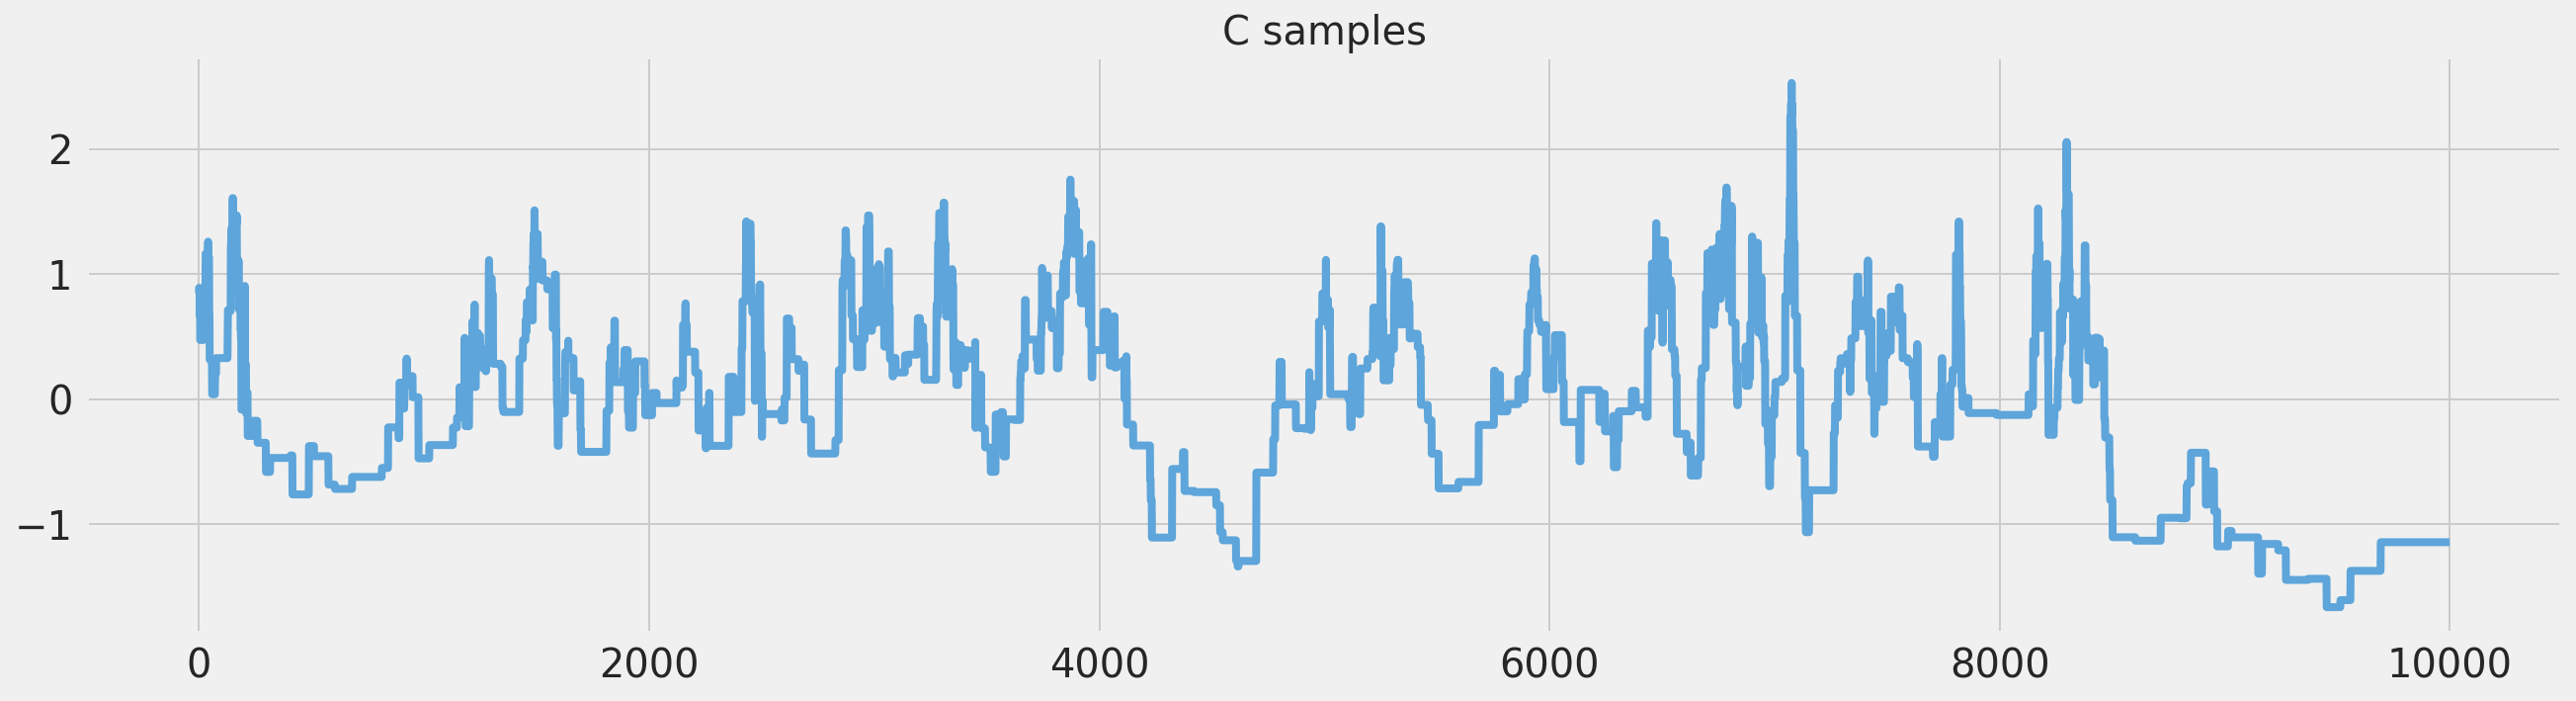

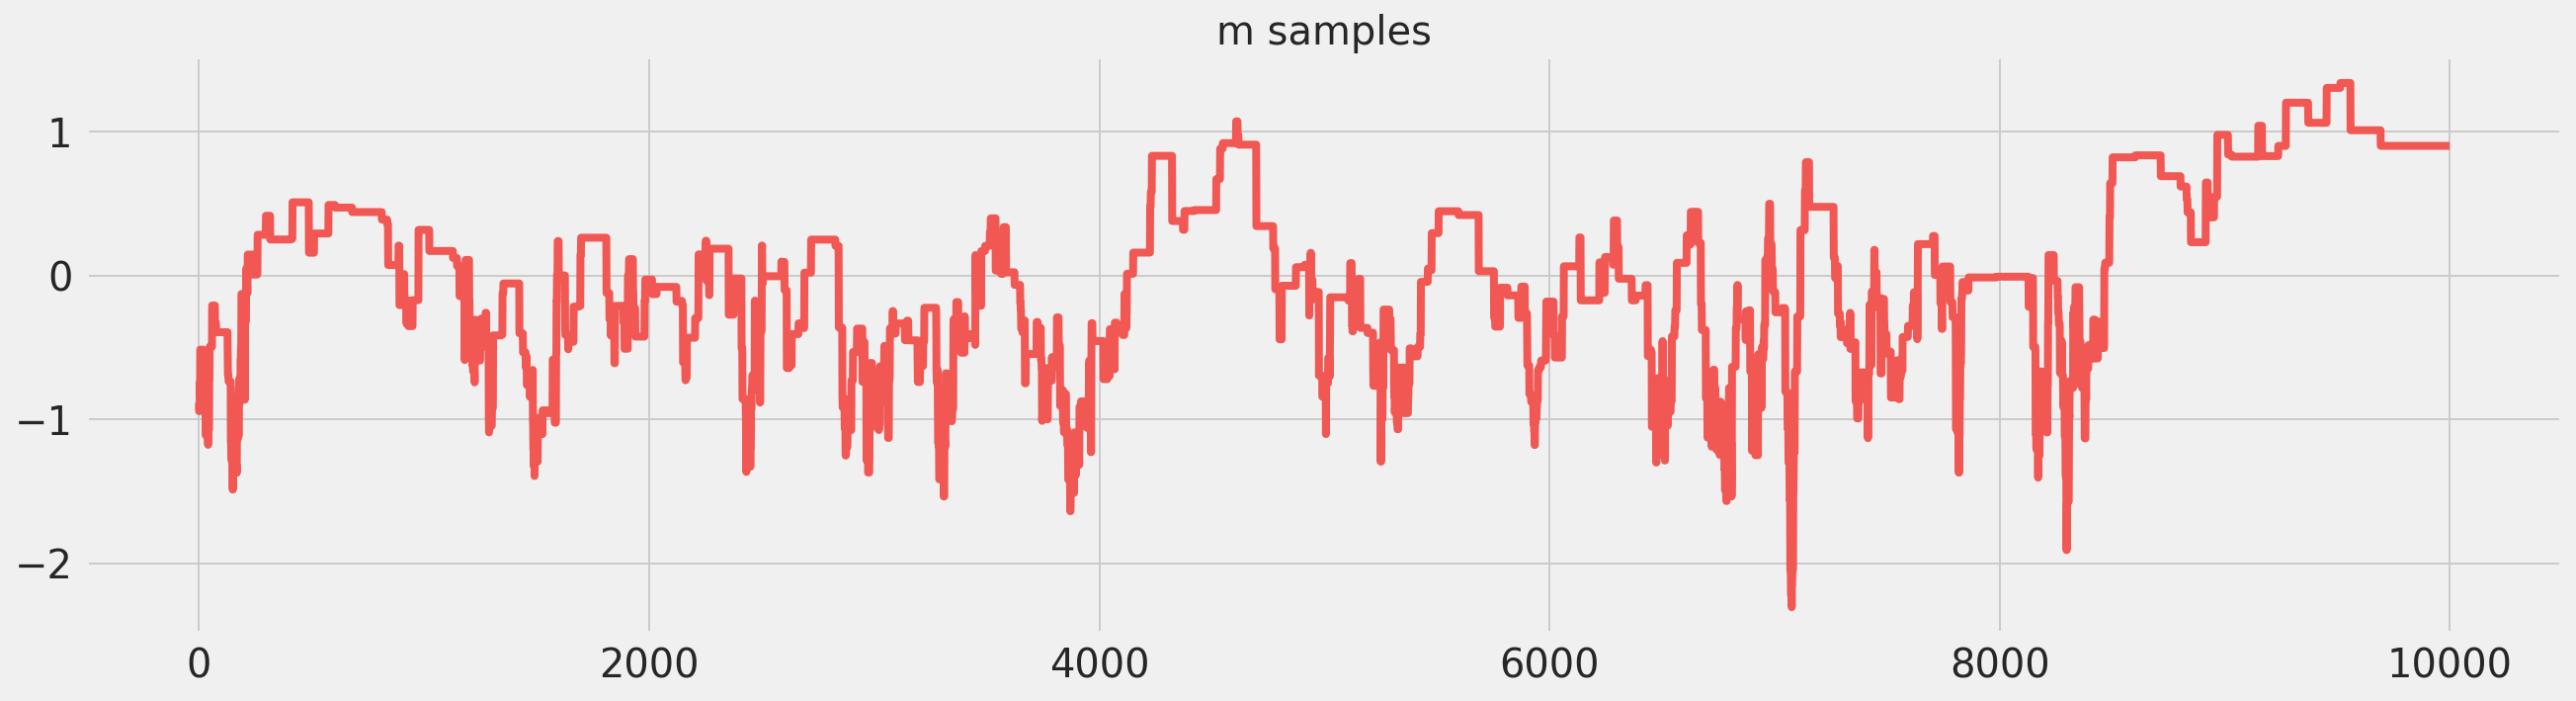

In [8]:
import matplotlib.pyplot as plt; plt.style.use('fivethirtyeight')
# plotting the mcmc chains
plt.figure(figsize=(20,5))
plt.plot(np.arange(samples), logC_samples_, color=TFColor[3])
plt.title('C samples',fontsize=20)

plt.figure(figsize=(20,5))
plt.plot(np.arange(samples), m_samples_, color=TFColor[0])
plt.title('m samples',fontsize=20)


If we collect our sample and rescale them to the original space, we can get some summary statistics on the posterior estimates of the calibrated parameters $\log(C)$ and $m$ and take a look at the distributions:

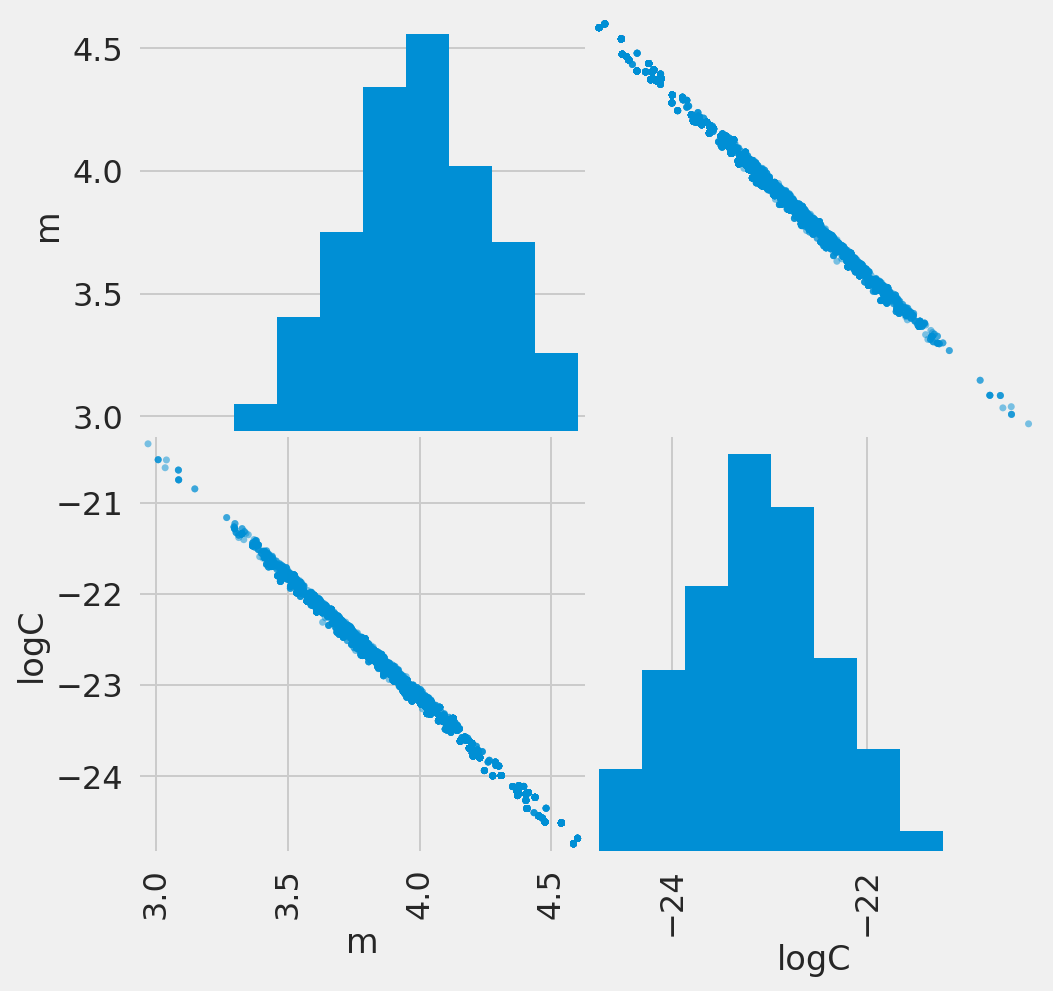

In [9]:
# Converting to proper scale
logC_samples_scale = logC_samples_ * np.sqrt(prio_par_logC[1]) + prio_par_logC[0]
m_samples_scale = m_samples_ * np.sqrt(prio_par_m[1]) + prio_par_m[0]
df = pd.DataFrame(np.concatenate([m_samples_scale[:,None], logC_samples_scale[:,None]], axis = 1), columns = ['m', 'logC'])

ax = pd.plotting.scatter_matrix(df,figsize=(7.2,7.2))

for axi in ax:
    axi[0].tick_params(labelsize=16)
    axi[1].tick_params(labelsize=16)

It is interesting to note that although we started off with two independent Gaussian distributions for $C$ and $m$, the posterior distributions are highly correlated. This is because, the solution space dictates that for high values for m, the only physically meaningful results lie at small values of C and vice-versa. If one were to have used any number of deterministic optimization techniques to find the "best fit" for $C$ and $m$ that fits this dataset, we could end up in any value that lies on the straight line depending on our starting point and constraints. Performing a probabilsitic optimization (a.k.a. Bayesian calibration) provides us with a global view of all possible solutions that can explain the dataset.


In [10]:
df.describe(percentiles=[.05, .95])

,m,logC
count,10000.000000,10000.000000
mean,3.994040,-23.133997
std,0.268388,0.725201
min,2.969397,-24.743921
5%,3.537173,-24.356779
50%,3.994371,-23.117020
95%,4.411884,-21.913601
max,4.598876,-20.350119


### Sampling the Posterior for Prognostic

And now for the final act, we shall define a posterior function for our probabilistic crack propagation model, in order to finaly make the prognostic:


In [0]:
def posterior(logC_samples, m_samples, time):
    n_s = len(logC_samples)
    n_inputs = len(time)

    # Some Constants
    dsig = 75.
    B = tf.constant(dsig * np.pi**0.5, tf.float32)

    # Crack Propagation model - compute in the log space

    y_model =(
        time[:,None]  *
        tf.exp(logC_samples[None,:])*
        (1-m_samples[None,:]/2.0) *B**m_samples[None,:] +y0** (1-m_samples[None,:]/2.0))**(2. / (2. - m_samples[None,:]))
    noise = tfd.Normal(loc=0., scale=0.001)
    samples = y_model + noise.sample(n_s)[tf.newaxis,:]
    # The evaluate() function, defined at the top of this notebook, runs `sess.run()` 
    # in graph mode and allows code to be executed eagerly when Eager mode is enabled
    samples_ = evaluate(samples)

    return samples_

In [12]:
# Predict for a range of cycles
time = np.arange(0, 3000, 100)
y_samples = posterior(logC_samples_scale, m_samples_scale, time)
print(y_samples.shape)

(30, 10000)


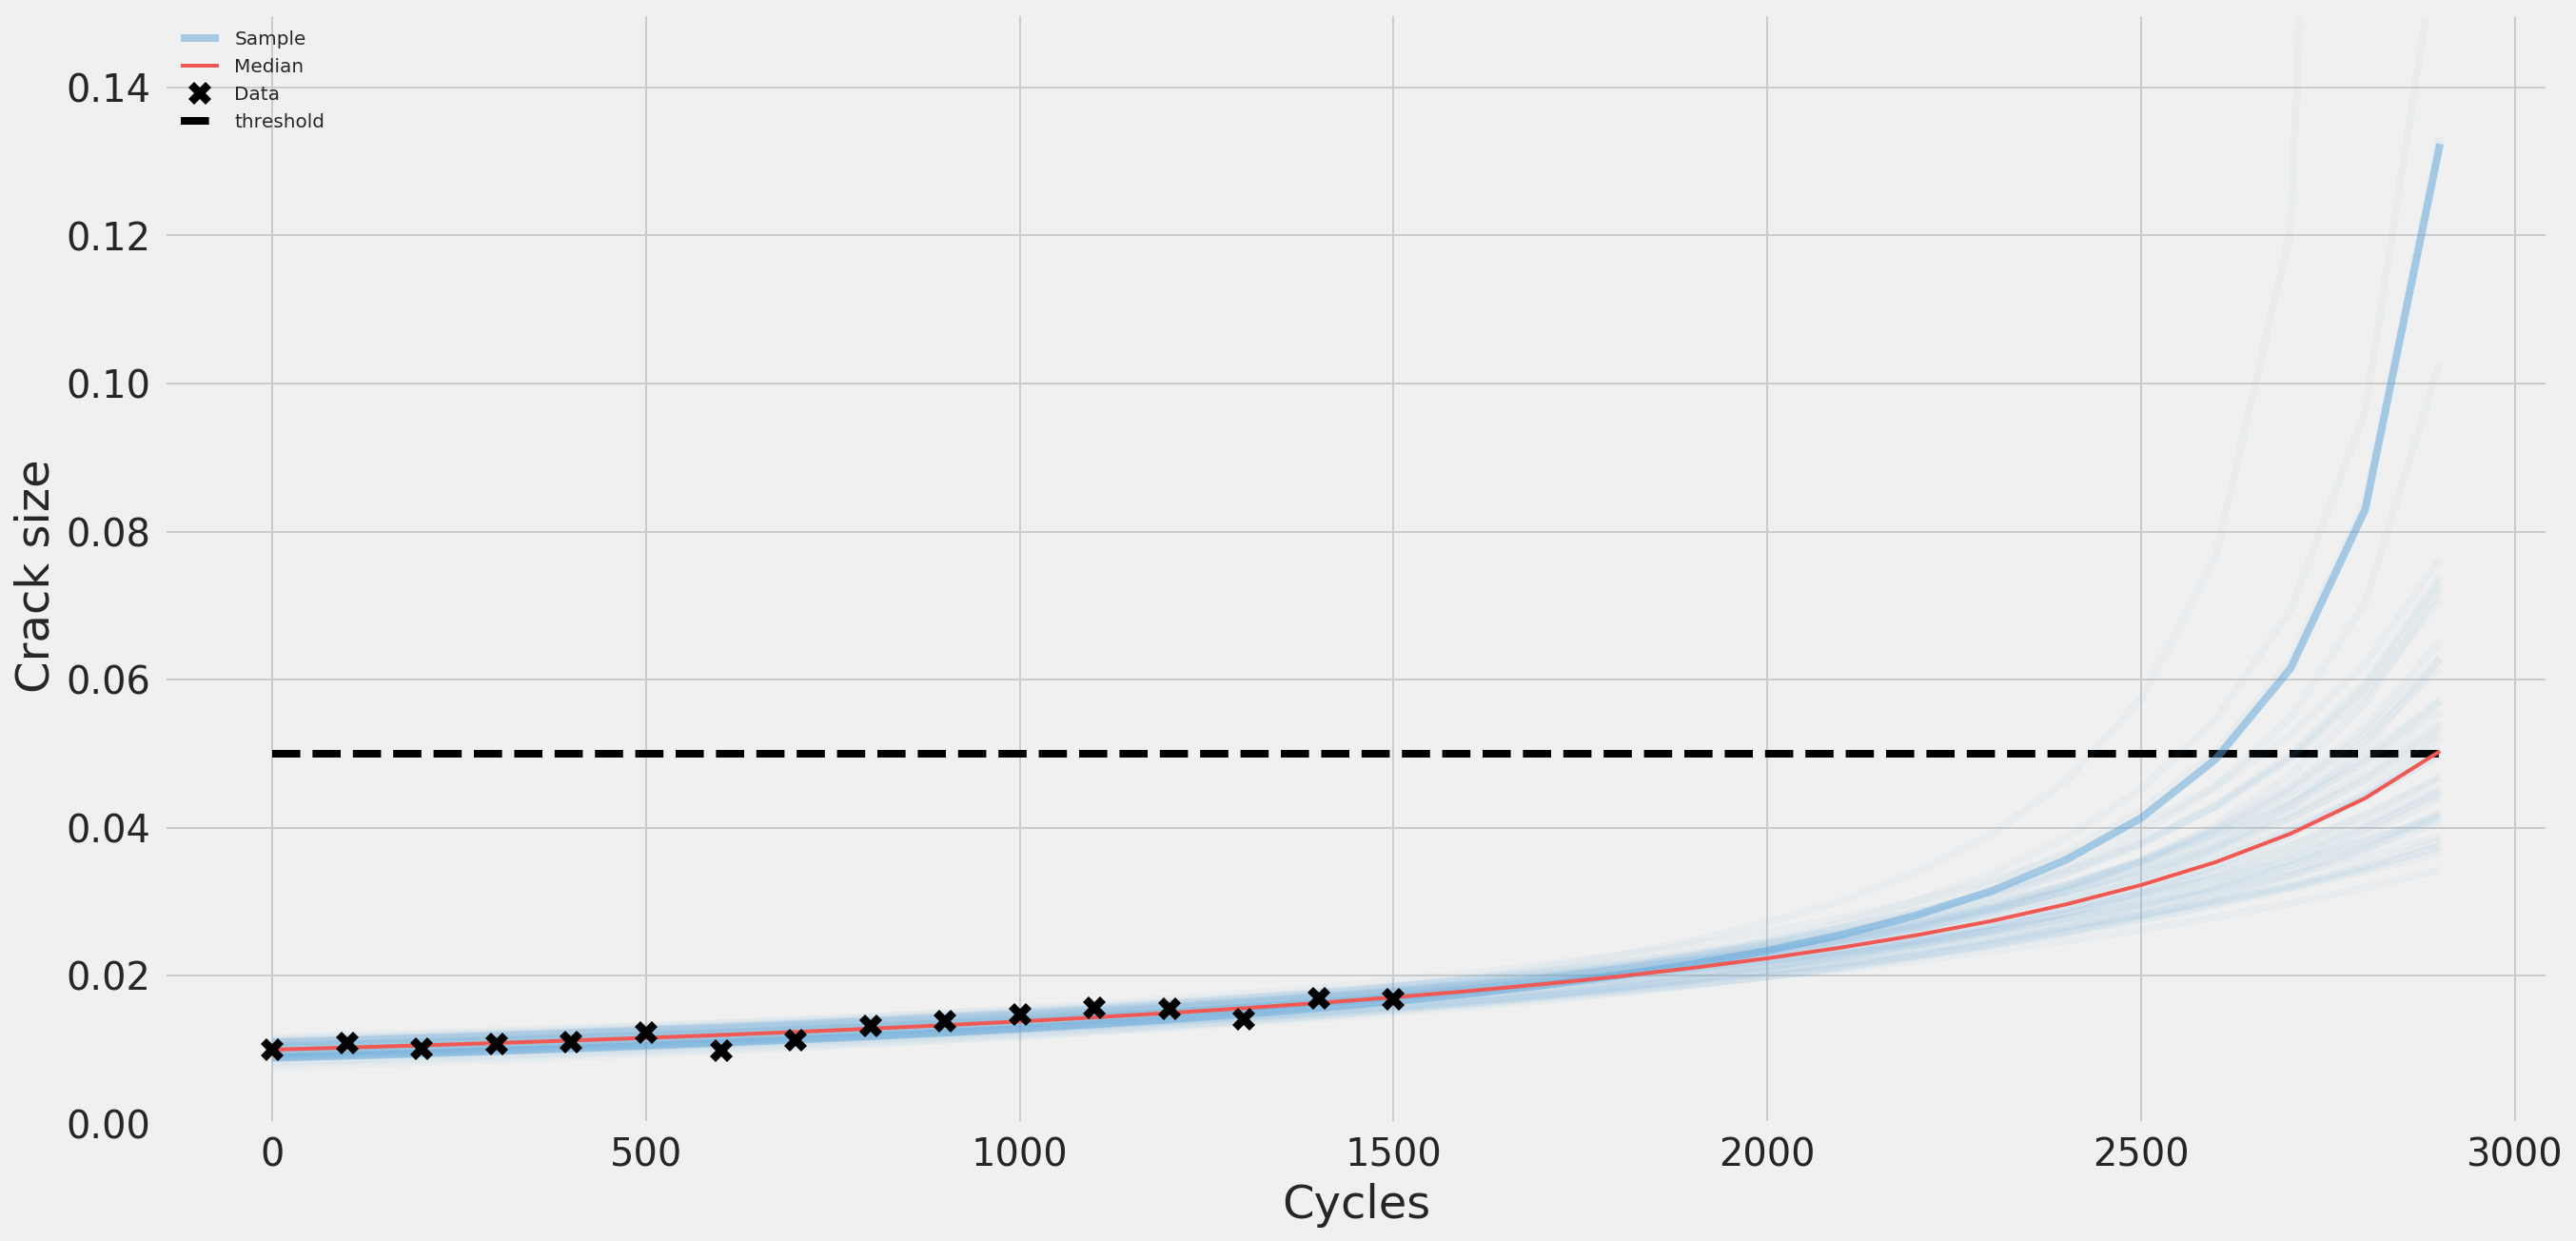

In [13]:
font = {'family' : 'Dejavu Sans','size'   : 20}
matplotlib.rc('font', **font)


#lower_per = np.percentile(y_samples,2.5, axis = 1)
#upper_per = np.percentile(y_samples,97.5, axis = 1)
lower_per = np.nanpercentile(y_samples, 2.5, axis = 1)
upper_per = np.nanpercentile(y_samples, 97.5, axis = 1)

plt.figure(figsize =(20,10))

for samps in range(y_samples.shape[1]):
    if samps % 250 == 0:
        plt.plot(time, y_samples[:,samps],color=TFColor[3], alpha = 0.05)

plt.plot(time, y_samples[:,-1],color=TFColor[3], label='Sample',alpha = 0.5)
plt.plot(time, np.nanmedian(y_samples,axis=1), TFColor[0], label = 'Median',linewidth=2)
plt.plot(t_,y_,'X', color='black', label = 'Data', markersize=12)
plt.xlabel('Cycles')
plt.ylabel('Crack size ')
plt.hlines(0.05, np.min(time), np.max(time), linestyles = '--', label = 'threshold')
plt.ylim([-0., 0.15])
plt.legend(loc=2)

The predicted mean with the 95% uncertainty bounds of crack length using the hybrid-physics probabilistic model is shown below. Clearly, the model captures both the mean behavior as well as provides an estimate of uncertainty (of the model prediction) for every time point. 

## Next steps
We have obviously chosen the example carefully to provide a gentle introduction to probabilistic models. There are several challenges in applying probabilistic models to real-world applications. Even in a simple problem like the one shown here, the solution becomes difficult if we relax the assumption that the priors are Gaussian. The more inquisitive reader can try using uniform priors to see the dramatic change in the predictive capability of the model. We will address some of the more practical challenges and their mitigation in the next blogs.

This is the first of a series of blogs aimed at expanding the use of Probabilistic and Deep Learning techniques for industrial applications with TensorFlow Probability. We would love to hear about your applications and look forward to seeing these methods used in unique ways. Stay tuned to this blog feed for more updates and examples on anomaly detection, missing data estimation and forecasting with variational inference.

### Acknowledgments

This blog is a result of the hard work and deep collaboration of several teams in Google and BHGE. We are particularly grateful to Josh Dillon, Michael Shwe, Scott Fitzharris, Alex Walker, Christian Hillaire and Fabio Nonato for their many edits, results, code snippets and most importantly enthusiastic support.